# 计算机网络体系结构第一次作业

## 实验设置

买卖的最小单位是一手，即 100 份。

### 买入

若忽略起点，买入费率为 0.038%

- 考虑买入证券交易费：过户费、佣金
- 过户费：按成交股票的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = deltaPosition * stockToday["收盘"]
costBuy = deltaPositionValue*0.02/1e3 + max(deltaPositionValue*0.018/100, 5)
#self.cash -= deltaPosition * stockToday["收盘"]
self.cash = self.cash - deltaPositionValue - costBuy

#没有考虑self.cash不够，出现负数的情况
```

### 卖出

若忽略起点，买入费率为 0.043%

- 考虑买入证券交易费：印花税、过户费、佣金
- 印花税：单向收取，卖出成交金额的万分之五（5‱）印花税由政府收取
- 过户费：按成交股票的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = pos["头寸"] * stockToday["收盘"]
costSell = deltaPositionValue*(1e-3 + 0.02/1e3) + max(deltaPositionValue*0.018/100, 5)
```


## 实验代码及说明


### 准备依赖


In [477]:
# !python -m pip install akshare matplotlib numpy pandas PyPortfolioOpt scipy

In [478]:
import akshare as ak
import calendar
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import mpl
import os

# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False

### 准备实验数据


In [479]:
stockNameCodes: list[tuple[str, str]] = [
    ("512200", "房地产ETF"),
    ("513050", "中概互联网ETF"),
    ("510300", "沪深300ETF"),
    ("510050", "上证50ETF"),
    ("510500", "中证500ETF"),
    ("159915", "创业板ETF"),
    ("159902", "中小100ETF"),
    ("512010", "医药ETF"),
    ("512880", "证券ETF"),
    ("512580", "环保ETF"),
    ("159920", "恒生ETF"),
    ("510900", "H股ETF"),
    ("513500", "标普500ETF"),
    ("513100", "纳指ETF"),
    ("512660", "军工ETF")
]


def Preprocess(startDate: datetime.datetime, endDate: datetime.datetime):
    # 获取标的历史数据
    startDate = startDate - datetime.timedelta(days=365)

    allStockDaily: dict[str, pd.DataFrame] = {}
    path = f'data/{startDate.strftime("%Y")}-{endDate.strftime("%Y")}'
    if os.path.exists(path):
        print(f'使用已有数据({startDate.strftime("%Y")}-{endDate.strftime("%Y")})')
        for code, name in stockNameCodes:
            try:
                stockDaily = pd.read_csv(os.path.join(
                    path, f"{name}_{code}.csv"), sep=',')
                stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])
                stockDaily = stockDaily.set_index("日期", drop=False)

                allStockDaily[code] = stockDaily
            except:
                print(f'{name}({code})读取失败!')
                continue
        return allStockDaily

    os.makedirs(path)
    for i, (code, name) in enumerate(stockNameCodes):
        print(f"{i}. {name}({code}) 正在读取数据...")
        try:
            # stockDaily = ak.stock_zh_a_hist(
            stockDaily = ak.fund_etf_hist_em(
                symbol=code,
                period="daily",
                start_date=startDate.strftime("%Y%m%d"),
                end_date=endDate.strftime("%Y%m%d"),
                adjust="hfq",
            )
        except:
            print(
                f'{name}({code}): {startDate.strftime("%Y-%m-%d")}--{endDate.strftime("%Y-%m-%d")}读取失败!'
            )
            continue
        try:
            # print(stockDaily.columns)
            stockDaily = stockDaily[stockDaily["开盘"].notnull()]
            stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])

            stockDaily.to_csv(os.path.join(
                path, f"{name}_{code}.csv"), index=False)
            stockDaily = stockDaily.set_index("日期", drop=False)

            allStockDaily[code] = stockDaily
        except:
            print(
                f'{name}({code}): {startDate.strftime("%Y-%m-%d")}--{endDate.strftime("%Y-%m-%d")}处理失败!'
            )
            continue
    return allStockDaily


start = datetime.datetime(2017, 9, 1)
end = datetime.datetime(2024, 3, 14)
allStockDaily = Preprocess(start, end)
print(f"共有{len(allStockDaily)}个标的数据")

使用已有数据(2016-2024)
共有15个标的数据


<Axes: title={'center': '各 ETF 走势'}, xlabel='日期'>

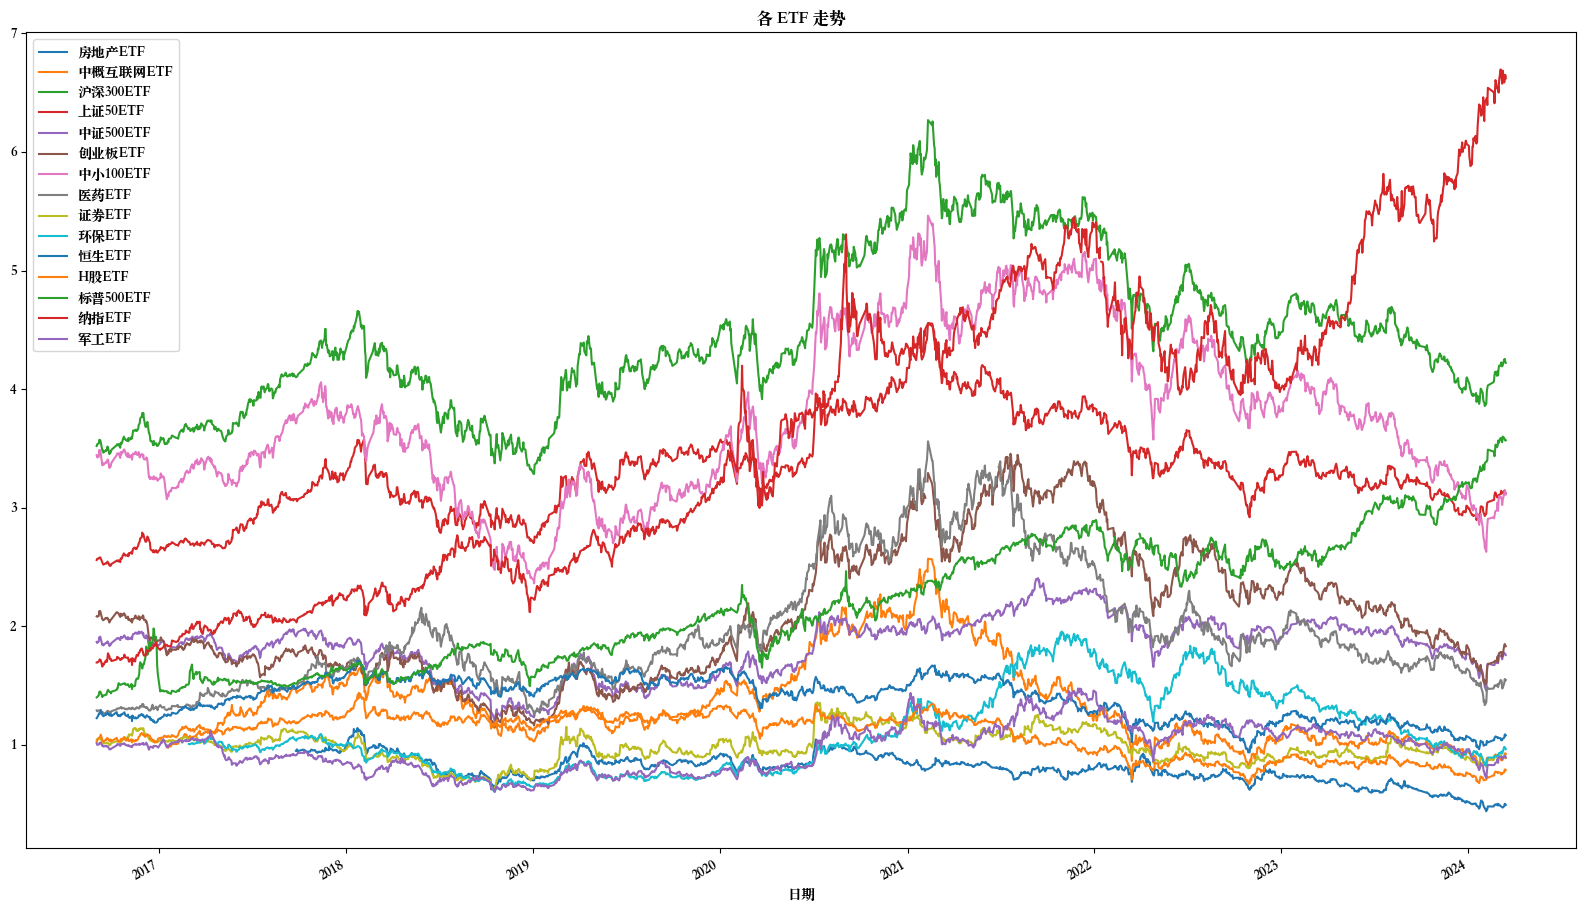

In [480]:
# 股价走势
df_prices: pd.DataFrame = pd.concat([i.iloc[:, 2]
                                  for _, i in allStockDaily.items()], keys=[i[1] for i in stockNameCodes], axis=1)
df_prices.plot(figsize=(20, 12), title='各 ETF 走势')

<Axes: title={'center': '各 ETF 走势（初始值标准化为 1）'}, xlabel='日期'>

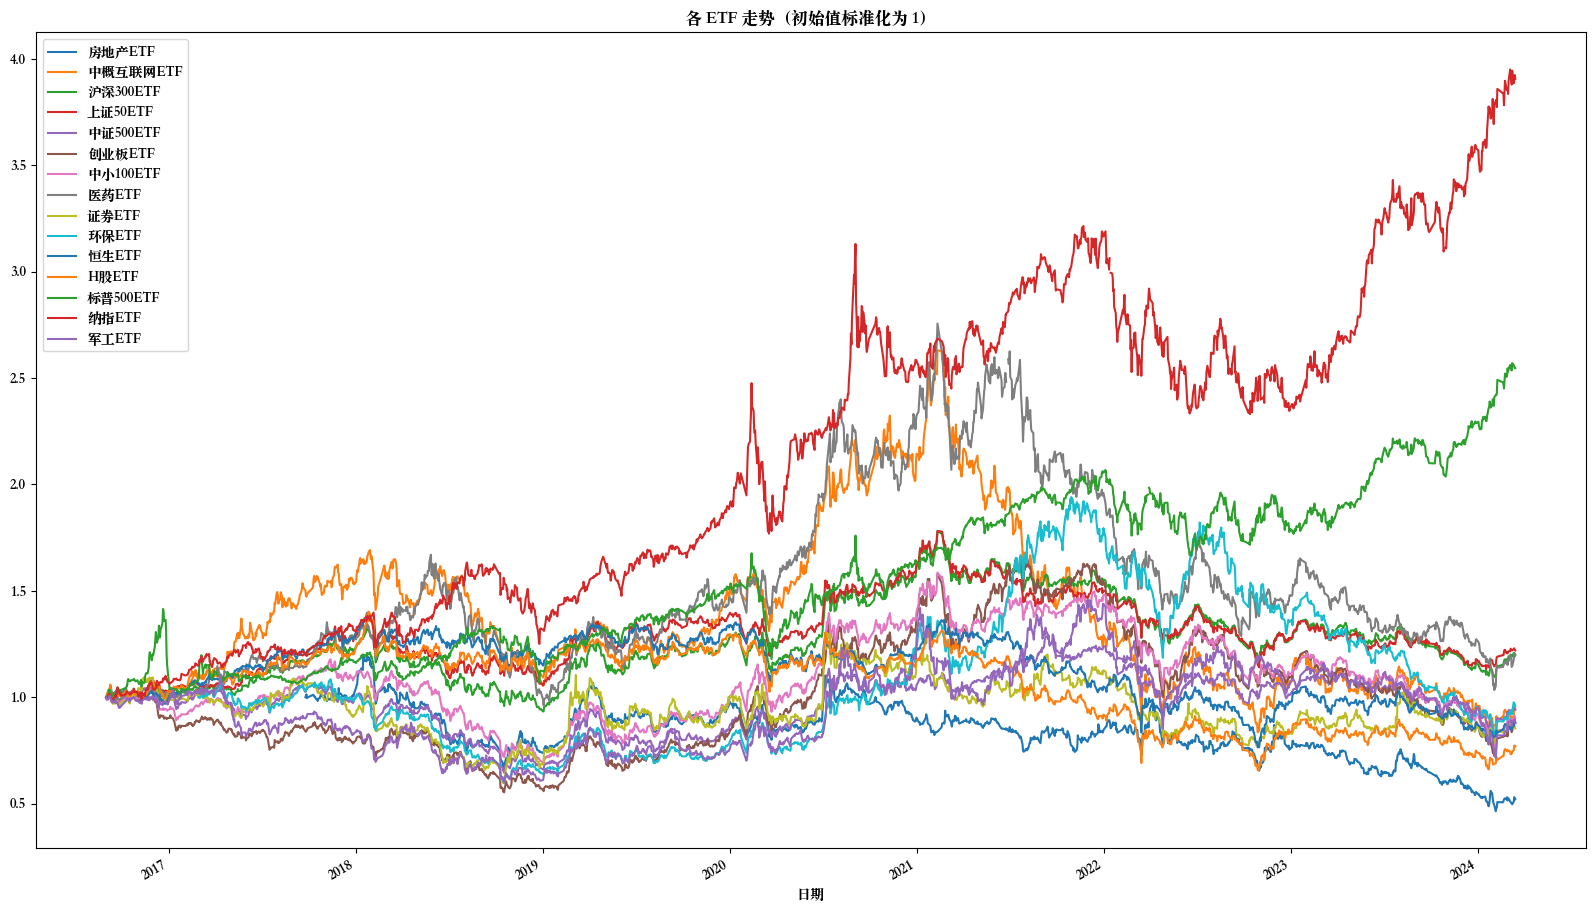

In [481]:
# 股价（初始值标准化为 1）走势
prices_normalized: pd.DataFrame = pd.concat([i.iloc[:, 2]/i.iloc[0, 2]
                                             for _, i in allStockDaily.items()], keys=[i[1] for i in stockNameCodes], axis=1)
prices_normalized.plot(figsize=(20, 12), title='各 ETF 走势（初始值标准化为 1）')

In [482]:
class ExtraCost:
    '''
    记录交易费用：过户费、佣金、印花税。
    '''
    __counter = 0
    __silent = False
    __warn = False

    def __init__(self, silent: bool = False):
        self.__silent = silent

    def get(self):
        return self.__counter

    def buy(self, num: float, store: bool):
        assert num >= 0, "买入数量必须不小于 0。"
        if num > 0:
            brokerage = round(num * 18 / 1e5, 2)
            if self.__warn and brokerage < 5:
                print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
            extra = round(round(num / 5000, 2) + max(5, brokerage), 2)
            if store:
                self.__counter += extra
            return round(num + extra, 2)
        else:
            if self.__warn:
                print("资金不足，无法购买。")
            return 0

    def sell(self, num: float, store: bool):
        assert num >= 0, "卖出数量必须不小于 0。"
        if num > 0:
            brokerage = round(num * 18 / 1e5, 2)
            if self.__warn and brokerage < 5:
                print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
            extra = round(round(num / 4000, 2) + max(5, brokerage), 2)
            if store:
                self.__counter += extra
            return round(num - extra, 2)
        else:
            return 0


# 1 表示开盘，2 表示收盘
D = 2

### 实验内容

#### 单个 ETF 上的测试


In [483]:
def calc(stockNameCode: tuple[str, str], step: datetime.timedelta, silent: bool = False) -> tuple[float, float, float]:
    '''
    Returns a tuple of (asset, ratio)
    '''
    df = allStockDaily[stockNameCode[0]]

    # 开始时间
    START = max(df.iloc[0, 0], start)
    END = min(df.iloc[-1, 0], end)

    # 总期数
    PERIODS_TOTAL: int = (END-START)//step+1
    # 剩余期数
    periods = PERIODS_TOTAL
    # 开始时间
    cur: pd.DatetimeIndex = START
    # 初始资金：每期五千
    # 似乎有点少，但是这样可以更好地体现出投资的风险
    INIT = 5000 * PERIODS_TOTAL
    money = INIT
    # 股票数量
    stocks = 0
    extra = ExtraCost(silent=silent)

    if not silent:
        print(f"开始计算{stockNameCode[1]}")
        print(f"总期数：{PERIODS_TOTAL}")
        print(f"开始时间：{cur}")
        print(f"初始资金：{money}")

    l = []

    i = 1
    for date, row in df.iterrows():
        # 日期
        date: pd.DatetimeIndex
        # 当日价格
        price: float = row[D]
        # 当前资产
        asset_now = ((money+extra.sell(stocks*price, store=False))
                     if stocks > 0 else money)/INIT
        l.append(pd.DataFrame([{'日期': date, '资产': asset_now}]))
        if cur <= date:
            # 本期准备使用的资金金额，大约每期 5000
            period_money = money/periods

            # 本期准备购买的股票数量（以 100 份为单位）
            stock_count = period_money//price//100

            # 本期准备购买的股票总价
            stock_price = stock_count*100*price
            while money < extra.buy(stock_price, store=False):
                stock_count -= 1
                stock_price = stock_count*100*price
                assert stock_count >= 0, f"剩余资金 {money} 不足以购买一手股票"
            money -= extra.buy(stock_price, store=True)
            assert money >= 0
            money = round(money, 2)
            stocks += stock_count*100
            if not silent:
                STOCK_PRICE = extra.sell(stocks*price, store=False)
                print(
                    f"第 {i} / {PERIODS_TOTAL} 期（{date}）: {money} + {STOCK_PRICE} = {round(money+STOCK_PRICE, 2)}")
            cur += step
            i += 1
            periods -= 1

    if not silent:
        ax = plt.axes(title=stockNameCode[1])
        # 当日与首日股票价格的比例
        normalized = df.iloc[:, D]/df.iloc[0, D]
        # 不太能理解的是这个地方为什么不能正常显示标签。
        normalized.plot(ax=ax, x='日期', y='开盘', label='当日开盘价与首日开盘价的比值')

        # 资产比值
        asset = pd.DataFrame(columns=['日期', '资产'])
        asset = pd.concat([asset, *l])
        asset.set_index('日期', drop=False, inplace=True)
        asset.plot(ax=ax, x='日期', y='资产', label='当日资产与初始资产的比值')
    price: float = df.iloc[-1, D]
    ratio: float = price/df.iloc[0, D]
    final = round(extra.sell(stocks*price, store=True), 2)
    asset_ratio = round(final+money, 2)/INIT
    if not silent:
        print(f"Remained Money: {money}")
        print(f"Stock: {stocks}")
        print(f"Price: {price}")
        print(f"Price Ratio: {ratio}")
        print(f"Stock Name: {stockNameCode[1]}")
        print(f"Total Extra Cost: {extra.get()}")
        print(f"Final Asset: {final} + {money} = {round(final+money,2)}")
        print(f"Final Asset Ratio: {asset_ratio}")
    return asset_ratio, ratio, extra.get()

开始计算房地产ETF
总期数：27
开始时间：2017-09-25 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-25 00:00:00）: 130054.01 + 4933.76 = 134987.77
第 2 / 27 期（2017-12-25 00:00:00）: 125092.42 + 9903.72 = 134996.14
第 3 / 27 期（2018-03-26 00:00:00）: 120107.62 + 14558.96 = 134666.58
第 4 / 27 期（2018-06-22 00:00:00）: 115177.44 + 18328.82 = 133506.26
第 5 / 27 期（2018-09-20 00:00:00）: 110237.95 + 21317.57 = 131555.52
第 6 / 27 期（2018-12-19 00:00:00）: 105261.16 + 25500.52 = 130761.68
第 7 / 27 期（2019-03-19 00:00:00）: 100310.27 + 37490.47 = 137800.74
第 8 / 27 期（2019-06-17 00:00:00）: 95310.47 + 39588.97 = 134899.44
第 9 / 27 期（2019-09-16 00:00:00）: 90362.58 + 44804.62 = 135167.2
第 10 / 27 期（2019-12-16 00:00:00）: 85417.39 + 50516.87 = 135934.26
第 11 / 27 期（2020-03-13 00:00:00）: 80390.49 + 53760.07 = 134150.56
第 12 / 27 期（2020-06-11 00:00:00）: 75374.49 + 57757.15 = 133131.64
第 13 / 27 期（2020-09-09 00:00:00）: 70428.5 + 70649.61 = 141078.11
第 14 / 27 期（2020-12-08 00:00:00）: 65450.51 + 72198.54 = 137649.05
第 15 / 27 期（2021-03-08 00:0

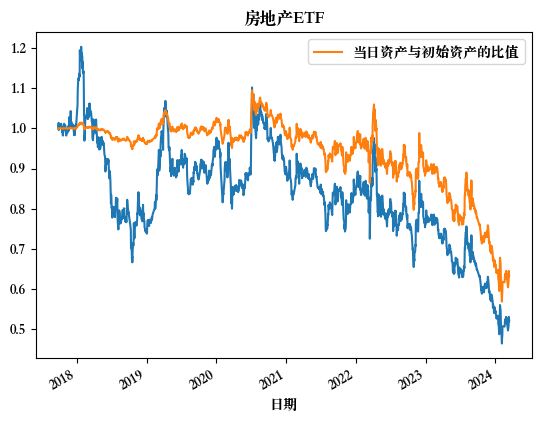

开始计算上证50ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-01 00:00:00）: 130027.61 + 4960.16 = 134987.77
第 2 / 27 期（2017-11-30 00:00:00）: 125137.63 + 10086.08 = 135223.71
第 3 / 27 期（2018-02-28 00:00:00）: 120228.15 + 15028.64 = 135256.79
第 4 / 27 期（2018-05-29 00:00:00）: 115337.37 + 18918.87 = 134256.24
第 5 / 27 期（2018-08-27 00:00:00）: 110581.02 + 23147.41 = 133728.43
第 6 / 27 期（2018-11-26 00:00:00）: 105733.45 + 27044.24 = 132777.69
第 7 / 27 期（2019-02-25 00:00:00）: 100832.97 + 35877.57 = 136710.54
第 8 / 27 期（2019-05-24 00:00:00）: 95806.17 + 39521.8 = 135327.97
第 9 / 27 期（2019-08-22 00:00:00）: 91082.23 + 47159.72 = 138241.95
第 10 / 27 期（2019-11-20 00:00:00）: 86232.26 + 53261.09 = 139493.35
第 11 / 27 期（2020-02-18 00:00:00）: 81456.51 + 57212.99 = 138669.5
第 12 / 27 期（2020-05-18 00:00:00）: 76460.01 + 60857.92 = 137317.93
第 13 / 27 期（2020-08-17 00:00:00）: 71368.39 + 76642.23 = 148010.62
第 14 / 27 期（2020-11-16 00:00:00）: 66654.85 + 81563.31 = 148218.16
第 15 / 27 期（2021-02-18 00

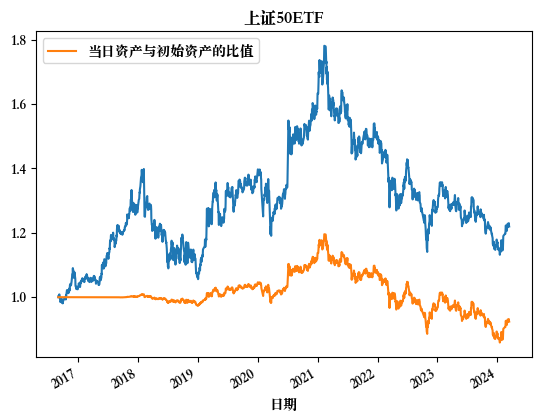

开始计算创业板ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-01 00:00:00）: 130021.21 + 4966.56 = 134987.77
第 2 / 27 期（2017-11-30 00:00:00）: 125026.21 + 9637.99 = 134664.2
第 3 / 27 期（2018-02-28 00:00:00）: 120067.22 + 14520.17 = 134587.39
第 4 / 27 期（2018-05-29 00:00:00）: 115195.05 + 19622.69 = 134817.74
第 5 / 27 期（2018-08-27 00:00:00）: 110198.05 + 21664.78 = 131862.83
第 6 / 27 期（2018-11-26 00:00:00）: 105216.05 + 23873.83 = 129089.88
第 7 / 27 期（2019-02-25 00:00:00）: 100286.47 + 33555.57 = 133842.04
第 8 / 27 期（2019-05-24 00:00:00）: 95298.07 + 36106.87 = 131404.94
第 9 / 27 期（2019-08-22 00:00:00）: 90319.28 + 45512.62 = 135831.9
第 10 / 27 期（2019-11-20 00:00:00）: 85348.29 + 53433.52 = 138781.81
第 11 / 27 期（2020-02-18 00:00:00）: 80326.29 + 72491.82 = 152818.11
第 12 / 27 期（2020-05-18 00:00:00）: 75426.71 + 75614.37 = 151041.08
第 13 / 27 期（2020-08-17 00:00:00）: 70467.42 + 101629.28 = 172096.7
第 14 / 27 期（2020-11-16 00:00:00）: 65483.42 + 107111.92 = 172595.34
第 15 / 27 期（2021-02-18 00:

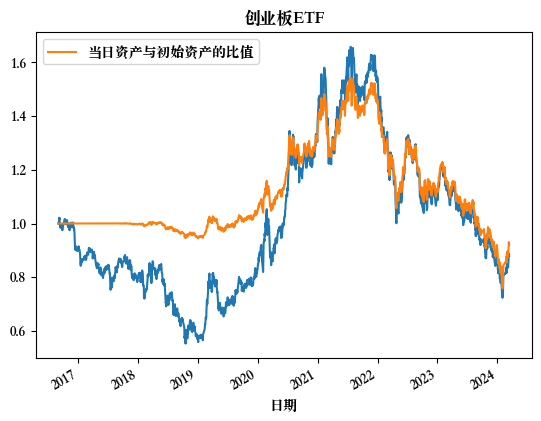

开始计算标普500ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-01 00:00:00）: 130030.81 + 4956.96 = 134987.77
第 2 / 27 期（2017-11-30 00:00:00）: 125058.62 + 10245.24 = 135303.86
第 3 / 27 期（2018-02-28 00:00:00）: 120183.65 + 15247.39 = 135431.04
第 4 / 27 期（2018-05-29 00:00:00）: 115323.68 + 20053.18 = 135376.86
第 5 / 27 期（2018-08-27 00:00:00）: 110401.0 + 27485.23 = 137886.23
第 6 / 27 期（2018-11-26 00:00:00）: 105456.31 + 30640.82 = 136097.13
第 7 / 27 期（2019-02-25 00:00:00）: 100578.34 + 36176.44 = 136754.78
第 8 / 27 期（2019-05-24 00:00:00）: 95674.56 + 42610.67 = 138285.23
第 9 / 27 期（2019-08-22 00:00:00）: 90653.16 + 50325.25 = 140978.41
第 10 / 27 期（2019-11-20 00:00:00）: 85719.97 + 58485.34 = 144205.31
第 11 / 27 期（2020-02-18 00:00:00）: 80807.99 + 68431.56 = 149239.55
第 12 / 27 期（2020-05-18 00:00:00）: 75768.38 + 64441.08 = 140209.46
第 13 / 27 期（2020-08-17 00:00:00）: 70896.01 + 78492.24 = 149388.25
第 14 / 27 期（2020-11-16 00:00:00）: 65957.62 + 84487.06 = 150444.68
第 15 / 27 期（2021-02-18 

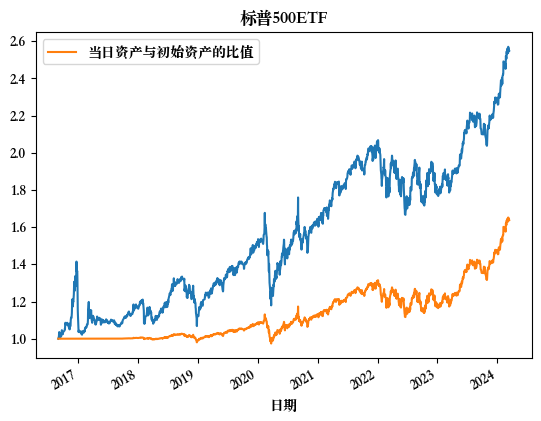

In [484]:
# 以房地产 ETF、上证 50 ETF、创业板 ETF、标普 500 ETF 为例
for i in [0, 3, 5, 12]:
    calc(stockNameCodes[i], datetime.timedelta(days=90))
    plt.show()

In [485]:
deltas = [
    datetime.timedelta(days=1),
    datetime.timedelta(days=2),
    datetime.timedelta(days=3),
    datetime.timedelta(days=7),
    datetime.timedelta(days=15),
    datetime.timedelta(days=30),
    datetime.timedelta(days=90),
    datetime.timedelta(days=180),
    datetime.timedelta(days=360),
    datetime.timedelta(days=1000),
]
res: list[pd.DataFrame] = []
for stockNameCode in stockNameCodes:
    l: list[pd.DataFrame] = []
    for delta in deltas:
        final, ratio, extra = calc(stockNameCode, delta, silent=True)
        l.append(pd.DataFrame({"标的": stockNameCode[1], "投资周期": [delta], "价格比例": [ratio],
                               "资产比例": [final], "交易费用": [extra]}, columns=["标的", "投资周期", "价格比例", "资产比例", "交易费用"]))
    res.append(pd.concat(l))

,1 天,2 天,3 天,7 天,15 天,30 天,90 天,180 天,365 天
标的,,,,,,,,,
房地产ETF,0.760,0.638,0.638,0.638,0.638,0.636,0.634,0.632,0.626
中概互联网ETF,0.813,0.718,0.718,0.716,0.719,0.717,0.717,0.699,0.697
沪深300ETF,0.961,0.941,0.941,0.941,0.942,0.940,0.939,0.923,0.945
上证50ETF,0.951,0.925,0.926,0.925,0.927,0.924,0.924,0.909,0.934
中证500ETF,0.989,0.983,0.983,0.984,0.983,0.979,0.980,0.962,0.961
创业板ETF,0.950,0.923,0.924,0.925,0.923,0.922,0.921,0.902,0.916
中小100ETF,0.899,0.845,0.845,0.846,0.845,0.842,0.840,0.822,0.838
医药ETF,0.867,0.798,0.798,0.799,0.800,0.800,0.798,0.807,0.813
证券ETF,0.954,0.930,0.931,0.931,0.931,0.928,0.925,0.897,0.905


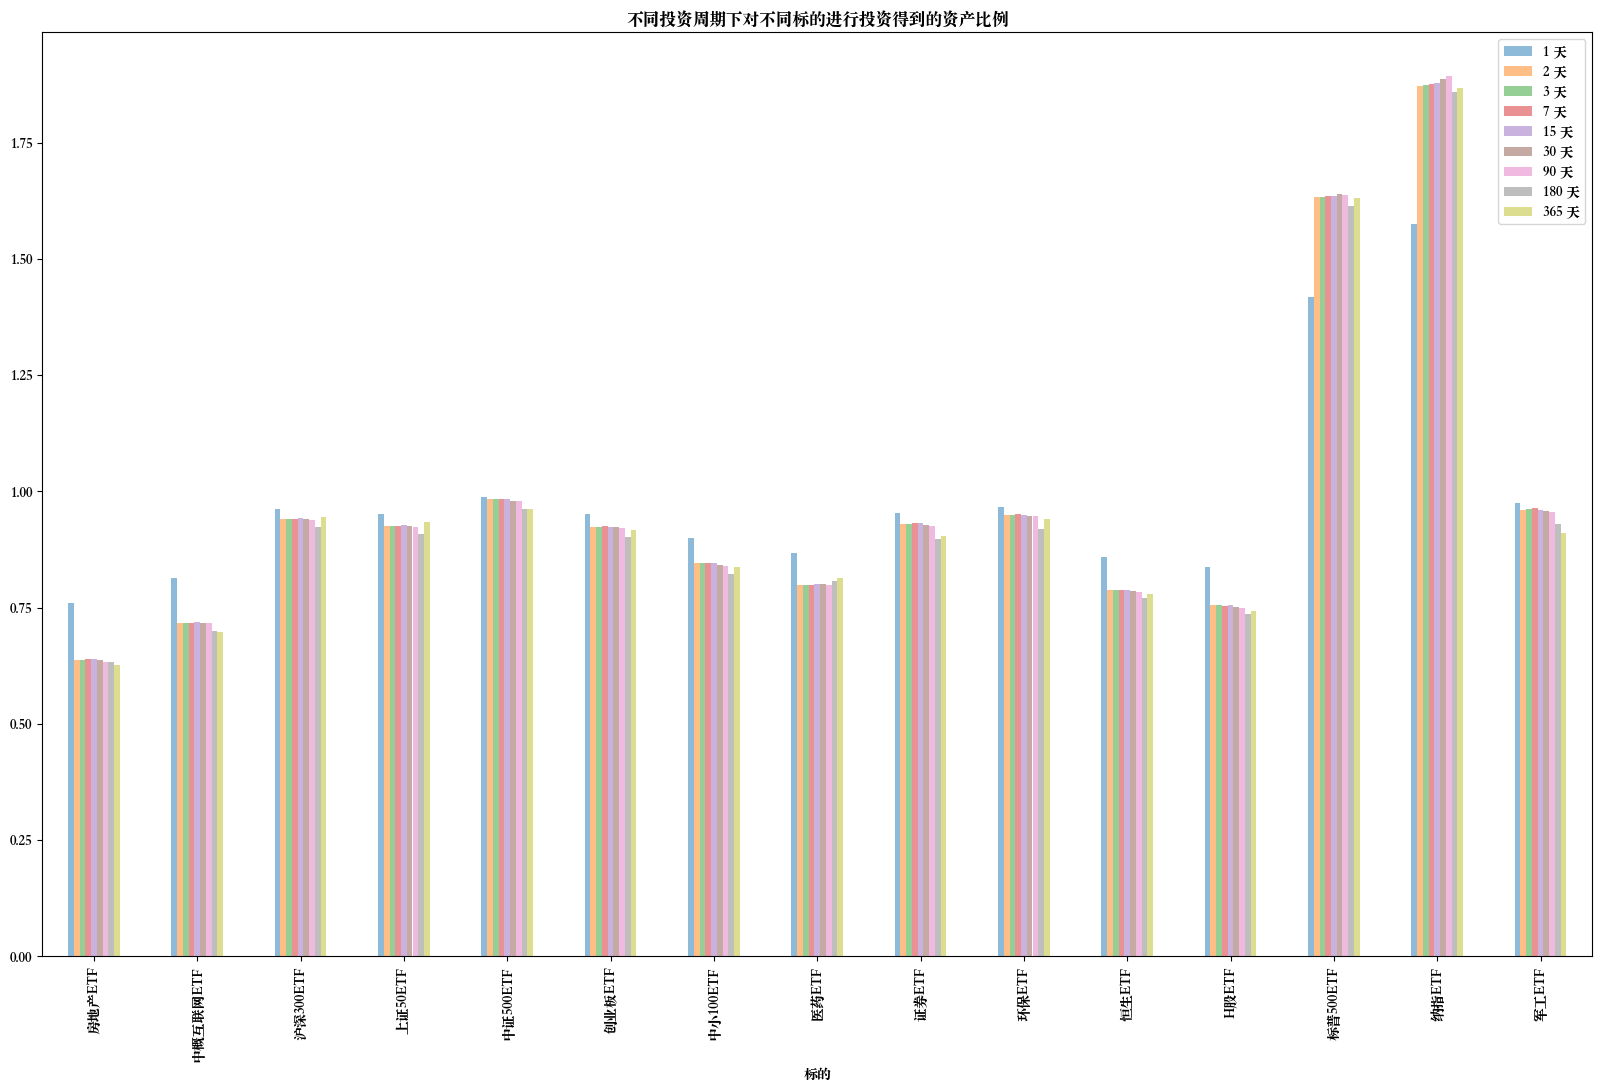

In [486]:
# 不同投资周期下使用五千元对不同标的进行投资，最终的资产比例。
# 表格中高亮部分对应该标的收益最高的投资周期。

# ax = plt.axes(title='不同投资周期下对不同标的进行投资得到的资产比例')
table: list[pd.DataFrame] = []
for i, l in enumerate(res):
    # l.plot(ax=ax, x='投资周期', y='资产比例', label=stockNameCodes[i][1])
    d = {'标的': stockNameCodes[i][1], }
    for j, delta in enumerate(deltas):
        d[f"{delta.days} 天"] = l.iloc[j, 3]
    table.append(pd.DataFrame.from_dict(d, orient='index').T)
# plt.show()

# for i, l in enumerate(res):
#     l.style.format(precision=3)

t = pd.concat(table)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
# print(t.idxmax(axis=1))
t.plot(kind='bar', alpha=0.5, figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资后的资产比值')
t.style.format(precision=3).highlight_max(axis='columns')

#### 计算投资组合


In [549]:
# 最大化夏普指数
# 为了最大化夏普指数，我们需要找到一个权重向量，使得夏普指数最大化。
# 夏普指数是投资组合的预期回报与投资组合风险之间的平衡。
# 夏普指数越高，投资组合的风险越低，回报越高。
# 夏普指数的计算公式为：
# Sharpe = (Rp - Rf) / σp
# 其中 Rp 是投资组合的预期回报，Rf 是无风险利率，σp 是投资组合的标准差。

from typing import Any
from scipy.optimize import OptimizeResult


def minimal_sharpley(log_returns: pd.DataFrame) -> OptimizeResult:
    from scipy.optimize import minimize
    # print(log_returns.shape)

    def stats(weights):
        weights = np.array(weights)
        port_returns = np.sum(log_returns.mean()*weights)*252
        port_variance = np.sqrt(
            np.dot(weights.T, np.dot(log_returns.cov()*252, weights)))
        return np.array([port_returns, port_variance, port_returns/port_variance])

    # 最小化夏普指数的负值
    def min_sharpe(weights: np.ndarray) -> float:
        # print(weights.shape)
        return -stats(weights)[2]

    # ETF 数量
    N = log_returns.shape[1]
    # 给定初始权重
    x0 = N*[1./N]

    # 权重（某股票持仓比例）限制在 0 和 1 之间。
    bnds = tuple((0, 1) for _ in range(N))

    # 权重（股票持仓比例）的总和为 1。
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

    # 优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
    opts = minimize(min_sharpe,
                    x0,
                    method='SLSQP',
                    bounds=bnds,
                    constraints=cons)
    return opts

In [630]:
# 根据一定策略调整投资组合。
# 动态计算收益率和风险，以及最优投资组合。
# 参考了 https://zhuanlan.zhihu.com/p/60499205

from pypfopt import expected_returns, risk_models
from scipy.stats import normaltest


def calc_portfolio(step: datetime.timedelta, silent: bool = False) -> tuple[float, float, float]:
    '''
    Returns a tuple of (asset, ratio)
    '''

    # 总期数
    PERIODS_TOTAL: int = (end-start)//step+1
    # 剩余期数
    periods = PERIODS_TOTAL
    # 开始时间
    cur: pd.DatetimeIndex = start
    # 初始资金：五千
    INIT = 5000*PERIODS_TOTAL
    money = INIT
    # 股票数量
    stocks = 0
    # 交易费用
    extra = ExtraCost(silent=silent)

    if not silent:
        print(f"总期数：{PERIODS_TOTAL}")
        print(f"开始时间：{cur}")
        print(f"初始资金：{money}")

    l = []

    i = 1

    # 房地产ETF
    stockNameCodesExcept = [(code, name)
                            for code, name in stockNameCodes if code != '512200']
    allStockDailyExcept = {code: stock for code,
                           stock in allStockDaily.items() if code != '512200'}

    # 持有量
    stocks = np.array([0 for _ in range(len(stockNameCodesExcept))])

    expectation = []
    for date in pd.date_range(start=start, end=end, freq=step):
        # 各标的当日价格
        prices = [stock.loc[start:date].iloc[:, D].to_numpy()
                  for _, stock in allStockDailyExcept.items()]
        # print(prices)
        prices = [p[-1] for p in prices]
        # print(prices)
        prices = np.array(prices)
        # print(prices,)

        df_prices = {}
        for code, stock in allStockDailyExcept.items():
            df_prices.setdefault(code, stock.loc[:date].iloc[:, D])
        df_prices = pd.DataFrame.from_dict(df_prices)
        # print(prices)

        log_returns = np.log(df_prices.pct_change()+1)
        ex = minimal_sharpley(log_returns)
        expectation.append(ex)

        # print(stocks)
        # print(prices)
        # print(money)
        asset: float = stocks.dot(prices)+money
        # 预期的投资组合比例
        weight: np.ndarray = ex.x
        # 预期的份数，未取整
        expected_stocks = weight*asset/prices
        expected_stocks_rounded = np.round(expected_stocks, -2)
        # 实际的投资组合比例
        actual = stocks*prices/asset
        diff_stocks = expected_stocks_rounded-stocks
        # print(diff_stocks)
        diff = [*enumerate(diff_stocks)]
        diff.sort(key=lambda x: x[1], reverse=False)
        for i, diff_stock in diff:
            # 买入或卖出股票
            # 先卖出再买入
            if diff_stock > 0:
                # 买入
                while money < extra.buy(diff_stock*prices[i], store=False):
                    print(
                        f"剩余资金 {money} 不足以购买 {diff_stock} 份 {stockNameCodesExcept[i][1]}")
                    diff_stock -= 100
                money -= extra.buy(diff_stock*prices[i], store=True)
                stocks[i] += diff_stock
            elif diff_stock < 0:
                # 卖出
                money += extra.sell(-diff_stock*prices[i], store=True)
                stocks[i] += diff_stock
            assert money >= 0
            assert not stocks[stocks < 0].any(), f"股票数量 {stocks} 不能为负"

        print(money, stocks)
        # print(lower_bounds, upper_bounds, weight)

        # plt.plot(log_returns)
        # log_returns = log_returns.dropna()
        # log_returns.mean()*252
        if False:
            verification = []
            for code, name in stockNameCodes:
                if code == '512200':  # 房地产ETF
                    continue
                # print('\nResults for {}'.format(name))
                # print('-'*32)
                log_data = np.array(log_returns[code])
                log_data = log_data[~np.isnan(log_data)]    # 去除 NaN
                normaltestresult = normaltest(log_data)
                verification.append(
                    pd.DataFrame.from_dict(
                        {
                            'name': [name],
                            'statistic': [normaltestresult[0]],
                            'pvalue': [normaltestresult[1]]
                        }
                    )
                )

            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
            # 不太符合正态分布
            verification = pd.concat(verification)
            verification.set_index('name', inplace=True)
            # verification.style.format(precision=3).highlight_max(axis='columns')
            print(verification)
            verification.plot(y='pvalue', kind='bar',
                              title='正态性检验结果', figsize=(20, 12), yticks=[i*0.01 for i in range(0, 30)])

        # 让我们看看历史平均收益率和历史协方差
        if False:
            mu = expected_returns.mean_historical_return(
                df_prices, compounding=True, log_returns=True)
            S = risk_models.sample_cov(df_prices, log_returns=True)
            # print(date, mu, S, sep='\n')

    # 最优投资组合
    weights: pd.DataFrame = pd.DataFrame([i.x for i in expectation],
                                         columns=[name for _, name in stockNameCodesExcept])
    print(weights.round(3))
    weights.plot(figsize=(20, 12), title='最优投资组合')
    return (0, 0, 0)
    for date, row in df.iterrows():
        # 日期
        date: pd.DatetimeIndex
        # 当日价格
        price: float = row[D]
        # 当前资产
        asset_now = ((money+extra.sell(stocks*price, store=False))
                     if stocks > 0 else money)/INIT
        l.append(pd.DataFrame([{'日期': date, '资产': asset_now}]))
        if cur <= date:
            # 本期准备使用的资金金额
            period_money = money/periods

            # 本期准备购买的股票数量（以 100 份为单位）
            stock_count = period_money//price//100

            # 本期准备购买的股票总价
            stock_price = stock_count*100*price
            while money < extra.buy(stock_price, store=False):
                stock_count -= 1
                stock_price = stock_count*100*price
                assert stock_count >= 0, f"剩余资金 {money} 不足以购买一手股票"
            money -= extra.buy(stock_price)
            assert money >= 0
            money = round(money, 2)
            stocks += stock_count*100
            if not silent:
                STOCK_PRICE = extra.sell(stocks*price, store=False)
                print(
                    f"第 {i} / {PERIODS_TOTAL} 期（{date}）: {money} + {STOCK_PRICE} = {money+STOCK_PRICE}")
            cur += step
            i += 1
            periods -= 1

    if not silent:
        ax = plt.axes(title=stockNameCode[1])
        # 当日与首日股票价格的比例
        normalized = df.iloc[:, D]/df.iloc[0, D]
        # 不太能理解的是这个地方为什么不能正常显示标签。
        normalized.plot(ax=ax, x='日期', y='开盘', label='当日开盘价与首日开盘价的比值')

        # 资产比值
        asset = pd.DataFrame(columns=['日期', '资产'])
        asset = pd.concat([asset, *l])
        asset.set_index('日期', drop=False, inplace=True)
        asset.plot(ax=ax, x='日期', y='资产', label='当日资产与初始资产的比值')
    price: float = df.iloc[-1, D]
    ratio: float = price/df.iloc[0, D]
    final = round(extra.sell(stocks*price), 2)
    if not silent:
        print(f"Money: {money}")
        print(f"Stock: {stocks}")
        print(f"Price: {price}")
        print(f"Price Ratio: {ratio}")
        print(f"Stock Name: {stockNameCode[1]}")
        print(f"Total Extra Cost: {extra.get()}")
        print(f"Final: {final} + {money} = {round(final+money,2)}")
    return round(final+money, 2)/INIT, ratio, extra.get()

总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
88.02000000001135 [39800     0 20100     0     0     0  9100     0   600     0     0     0
  1200     0]
235.66000000001077 [30600     0 18300     0     0     0 12500     0     0     0     0     0
  7900     0]
195.0200000000109 [31900     0 18600     0     0     0 10400     0     0     0     0     0
  8100     0]
113.66000000001804 [19700     0  1800     0     0     0 36400     0     0     0     0     0
 15000     0]
剩余资金 61070.42000000001 不足以购买 22800.0 份 纳指ETF
256.7200000000157 [    0     0     0     0     0     0 20100     0     0     0     0     0
 37700     0]
剩余资金 13372.040000000015 不足以购买 5700.0 份 纳指ETF
142.80000000001564 [    0     0     0     0     0     0 11500     0     0     0     0     0
 43300     0]
118.01000000000931 [    0     0  9600     0     0     0     0     0     0  8800     0     0
 32600     0]
剩余资金 16515.30000000001 不足以购买 6300.0 份 纳指ETF
188.64000000001033 [    0     0  8700     0     0     0     0     0     0     0    

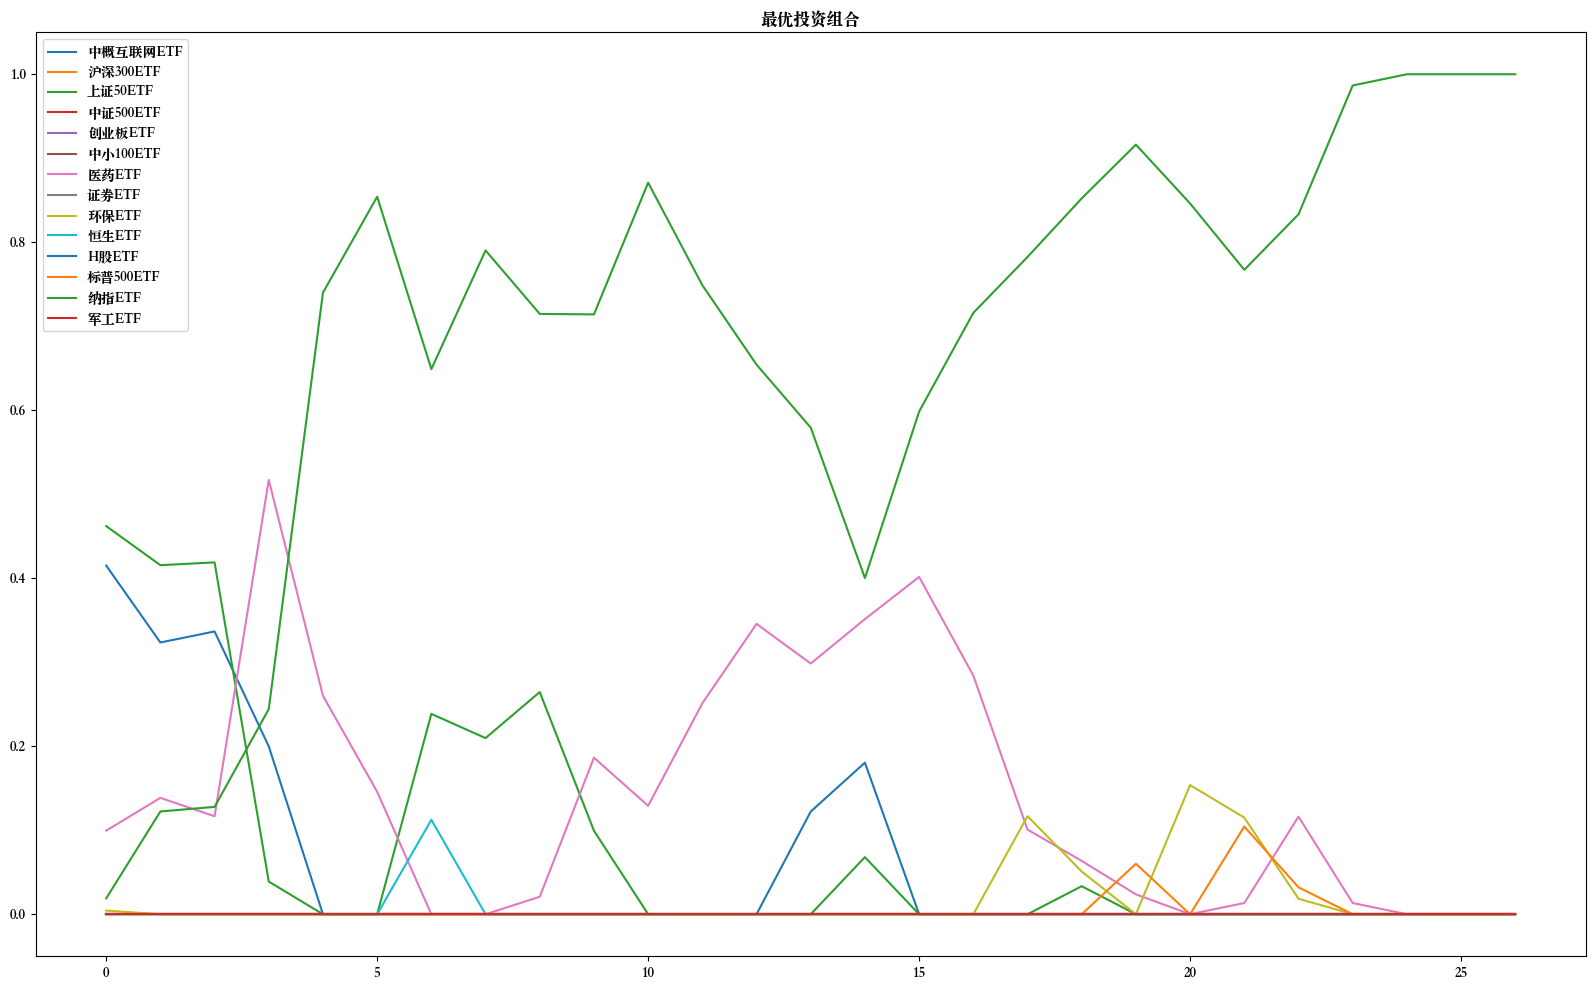

In [631]:
calc_portfolio(datetime.timedelta(days=90))
plt.show()

##### PyPortfolioOpt 库的使用


In [632]:
# 使用前几年的股价数据来决定投资组合并不会有太大的意义（之后腾飞的两只 ETF 在此时都平平无奇），
# 但是可以用来展示如何使用 PyPortfolioOpt 这个库。
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# https://pyportfolioopt.readthedocs.io/en/latest/

pre = datetime.datetime(2015, 9, 1)
allStockDailyPre = Preprocess(pre, start)

stockNameCodesPre = stockNameCodes.copy()
# 房地产 ETF 尚未上市
stockNameCodesPre.remove(("512200", "房地产ETF"))
# 与前面的 prices 相似，但没有除以首日的价格
df = pd.concat([i.iloc[:, 2]for _, i in allStockDailyPre.items()],
               keys=[i[1] for i in stockNameCodesPre], axis=1)
# df = pd.read_csv("../PyPortfolioOpt/tests/resources/stock_prices.csv",
#                  parse_dates=True, index_col="date")

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
w = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

print(ef.clean_weights())

使用已有数据(2014-2017)
房地产ETF(512200)读取失败!
Expected annual return: 75.4%
Annual volatility: 19.1%
Sharpe Ratio: 3.84
OrderedDict([('中概互联网ETF', 0.89361), ('沪深300ETF', 0.0), ('上证50ETF', 0.00855), ('中证500ETF', 0.0), ('创业板ETF', 0.0), ('中小100ETF', 0.0), ('医药ETF', 0.05079), ('证券ETF', 0.0), ('环保ETF', 0.04704), ('恒生ETF', 0.0), ('H股ETF', 0.0), ('标普500ETF', 0.0), ('纳指ETF', 0.0), ('军工ETF', 0.0)])


In [633]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(w, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio(reinvest=True, verbose=True)
print(allocation)

Funds remaining: 0.11
中概互联网ETF: allocated 0.894, desired 0.894
沪深300ETF: allocated 0.000, desired 0.000
上证50ETF: allocated 0.009, desired 0.009
中证500ETF: allocated 0.000, desired 0.000
创业板ETF: allocated 0.000, desired 0.000
中小100ETF: allocated 0.000, desired 0.000
医药ETF: allocated 0.051, desired 0.051
证券ETF: allocated 0.000, desired 0.000
环保ETF: allocated 0.047, desired 0.047
恒生ETF: allocated 0.000, desired 0.000
H股ETF: allocated 0.000, desired 0.000
标普500ETF: allocated 0.000, desired 0.000
纳指ETF: allocated 0.000, desired 0.000
军工ETF: allocated 0.000, desired 0.000
Allocation has RMSE: 0.000
{'中概互联网ETF': 12702, '上证50ETF': 55, '医药ETF': 692, '环保ETF': 927}
